# EE353 ASSIGNMENT 3
#### PRIYANSH SINGH
#### 22b1856
#### LINK TO THE EXPLANATORY VIDEO:

In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [278]:
#data handling and basic math libraries
import pandas as pd #pandas for csv file reading and dataframe handling
import numpy as np #numpy for basic matrix computations

#time library for complexity analysis
import time

#plotting libraries
import matplotlib.pyplot as plt #for scatter and line plots of arrays
import seaborn as sns #for heatmaps

#scikit-learn - model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

#scikit-learn - feature engineering
from sklearn.feature_selection import RFECV

#scikit-learn - Models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#scikit-learn - metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

#scikit-learn - feature importance
from sklearn.inspection import permutation_importance

#to save the trained models
import joblib

# Objective 1

### Reading the dataset file

In [143]:
data = pd.read_csv('/content/drive/My Drive/EE353 assignments/Assignment 3/bank.csv') #using pandas read csv to read the csv file
# data = pd.read_csv('bank.csv') #using pandas read csv to read the csv file

## Task 1 - EDA

### Data description [1]

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (column deposit in the dataset).

### Usable variables

### Looking at the dataset, the following columns can be deemed useless for the current task in hand: [1]
- $\textbf{Contact}$: Contact communication type - useless for identifying the effectiveness of the marketing campaign, is either of the type cellular or telephone, so it won't affect the outcome to a large extent
- $\textbf{Day}$: Last contact day of the year
- $\textbf{Month}$: Last contact minth of the year  
- $\textbf{Campaign}$: For a similar reason as above, the number of calls for the current campaign is useless for inference and for prediction.

In [144]:
# filtered_data = data.drop(['contact', 'day', 'month', 'campaign'], axis = 1) #removing the useless columns as discussed above
filtered_data = data

### Important column to handle
- $\textbf{Duration}$ - This is the duration in seconds for which the call lasted, and since this information is not present before the call began, we can't use this in our predictive model as we will be unable ot make any inference before the call itself. So there's a need to be careful with this column, the final decision regarding this column will be made after obtaining the feature importance values.[1]

### Data cleaning
- After a thorough search for missing/NaN values in the dataset, the only missing cells were the ones filled with "unknown", apart from which the data was completely clean

### Looking for the fraction of unknown values for each column  

In [145]:
print("Fraction of unknown entries in the following columns:") #printing the header
for column in filtered_data.columns: #iterating through the columns of the dataframe
    n_unknown = 0 #initializing the number of unknowns for this column
    for i in range(len(filtered_data[column])): #iterating through the column
        n_unknown += 1 if filtered_data[column][i] == 'unknown' else 0 #count the entry as unknown if it is 'unknown'
    print(f"{column}: {n_unknown/len(filtered_data[column]):.4f}") #printing the fraction of unknowns

Fraction of unknown entries in the following columns:
age: 0.0000
job: 0.0063
marital: 0.0000
education: 0.0445
default: 0.0000
balance: 0.0000
housing: 0.0000
loan: 0.0000
contact: 0.2102
day: 0.0000
month: 0.0000
duration: 0.0000
campaign: 0.0000
pdays: 0.0000
previous: 0.0000
poutcome: 0.7459
deposit: 0.0000


- Observation: the column poutcome (Contains results of the previous marketing campaign) has 75% of its entries unavailable, so this column is unreliable and hence can't be used for training/validation.
- Hence, dropping the poutcome column:

In [146]:
filtered_data = filtered_data.drop(['poutcome'], axis = 1) #removing the poutcome as discussed above

### Correlations among the variables

- A correlation heatmap can be plotted for the columns of the data, for which all columns have to be encoded into numerical values

In [147]:
#[3]
filtered_data_num = filtered_data.copy() # copying the filtered dataframe into a dataframe which will be numerically encoded

### Using One-hot encoding for all the non-binary categorical columns

In [148]:
#One-hot encoding for the columns: Job, Marital, Education
#[4]
filtered_data_num = pd.get_dummies(filtered_data_num, columns = ['job', 'marital', 'education', 'contact', 'month']) #using the get_dummies function in pandas
filtered_data_num = filtered_data_num.replace({False: 0, True: 1}) #encoding the yes as 1 and no as 0, "unknown" remaining "unknown"
filtered_data_num = filtered_data_num.drop(['job_unknown', 'education_unknown', 'contact_unknown'], axis = 1) #removing the one hot columns corresponding to unknown entries

<ipython-input-148-d6e0e5daa5f6>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_data_num = filtered_data_num.replace({False: 0, True: 1}) #encoding the yes as 1 and no as 0, "unknown" remaining "unknown"


In [149]:
print("Column Names:") #printing the column names
print("\n".join(filtered_data_num.columns)) #all columns of the filtered dataframe

Column Names:
age
default
balance
housing
loan
day
duration
campaign
pdays
previous
deposit
job_admin.
job_blue-collar
job_entrepreneur
job_housemaid
job_management
job_retired
job_self-employed
job_services
job_student
job_technician
job_unemployed
marital_divorced
marital_married
marital_single
education_primary
education_secondary
education_tertiary
contact_cellular
contact_telephone
month_apr
month_aug
month_dec
month_feb
month_jan
month_jul
month_jun
month_mar
month_may
month_nov
month_oct
month_sep


### Binary encoding for the binary columns
- default
- housing
- loan


In [150]:
filtered_data_num[['default', 'housing', 'loan', 'deposit']] = filtered_data_num[['default', 'housing', 'loan', 'deposit']].replace({'no': 0, 'yes': 1}) #encoding the yes as 1 and no as 0, "unknown" remaining "unknown"
filtered_data_num_X = filtered_data_num.drop(['deposit'], axis = 1) #Dataframe of the independent variables

<ipython-input-150-4fe1a7734a75>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_data_num[['default', 'housing', 'loan', 'deposit']] = filtered_data_num[['default', 'housing', 'loan', 'deposit']].replace({'no': 0, 'yes': 1}) #encoding the yes as 1 and no as 0, "unknown" remaining "unknown"


### Iteratively finding correlations between the columns
- NOTE: I am not using the filtered_data_num.corr() function due to the various columns containing "unknown" in multiple different rows, which would need removal of all such rows, significantly reducing the data size.

In [151]:
#[5]
corr_matrix = pd.DataFrame(np.nan, index=filtered_data_num_X.columns, columns=filtered_data_num_X.columns) #creating a column name indiced square matrix dataframe to hold the correlation values
for col1 in filtered_data_num_X.columns: #looping once through all the columns
    for col2 in filtered_data_num_X.columns: #second loop

        column1 = filtered_data_num_X[col1] #reading the col1 of filtered data
        column2 = filtered_data_num_X[col2] #reading the col2 of filtered data

        for i in column1.index[column1 == 'unknown']: #checking for unknown entries in col1
            column1.drop(i).reset_index(drop = True) #[6] dropping and resetting the rows with unknown entries
            column2.drop(i).reset_index(drop = True) #dropping and resetting the rows with unknown entries for col2

        for i in column2.index[column2 == 'unknown']: #checking for unknown entries in col1
            column1.drop(i).reset_index(drop = True) #[6] dropping and resetting the rows with unknown entries
            column2.drop(i).reset_index(drop = True) #dropping and resetting the rows with unknown entries for col2

        corr_matrix.at[col1, col2] = column1.corr(column2) #Correlation between col1 and col

<ipython-input-152-537bcb6503f2>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(corr_matrix, annot=corr_matrix.applymap(lambda x: 'X' if abs(x) > 0.6 else ''), fmt='', cmap='coolwarm', square=True, cbar_kws={"shrink": .8}) #annotated heatmap


Text(0.5, 1.0, 'Correlation heatmap for the dataset')

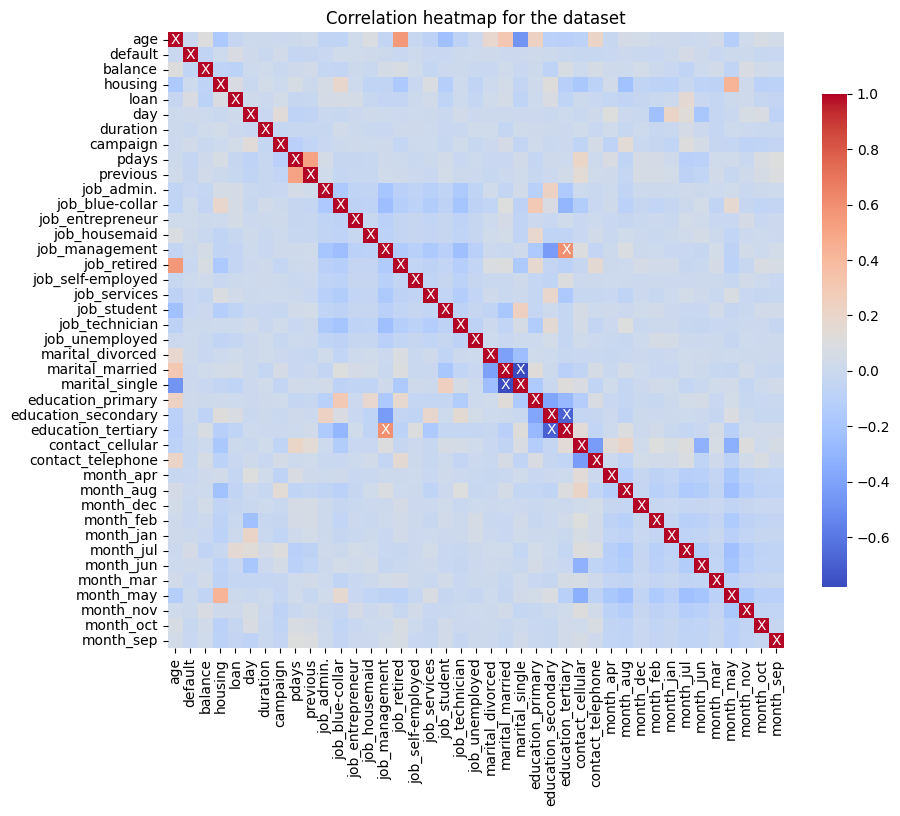

In [152]:
plt.figure(figsize = (10, 8)) #setting output figure size
#[7]
sns.heatmap(corr_matrix, annot=corr_matrix.applymap(lambda x: 'X' if abs(x) > 0.6 else ''), fmt='', cmap='coolwarm', square=True, cbar_kws={"shrink": .8}) #annotated heatmap
plt.title("Correlation heatmap for the dataset") #title for the heatmap

### Decision from the correlation heatmap:
- Due to high correlation between the job_retired column and the age column (which is logically expected), we can drop the job_retired column
- Apart from this pair, other correlated columns don't seem logical to be dropped

### Checking for balance in the output class

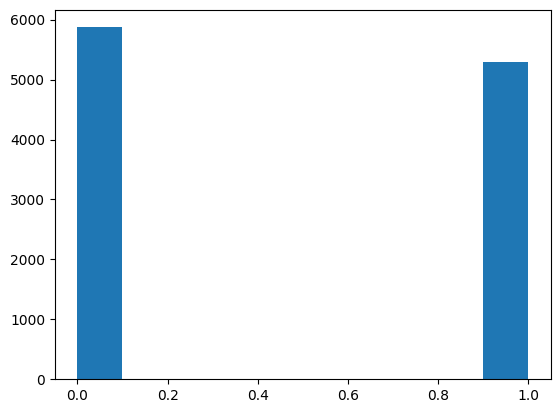

In [153]:
plt.hist(filtered_data_num['deposit']) #plotting a histogram of the deposit column
plt.show() #show the plot

- The above histogram suggests a pretty much balanced class column   

### Finally, removing all the rows with unknown cells to prepare the data for inference and training

In [279]:
for i in range(filtered_data_num.shape[0]): #iteratinf through all the sample points
    found_unknown = 0 #either found unknown in the row or not
    for column in filtered_data_num.columns: #iterating through all the columns for this row
        if(filtered_data_num[column][i] == 'unknown'): #On encountering an 'unknown'
           found_unknown += 1 #incrementing the found unknown counter
    if(found_unknown != 0): #drop this sample point if it has even one unknown entry
      filtered_data_num.drop(i) #[6] dropping and resetting the rows with unknown entries

## Task 2 - Choosing the metrics

- Since the data is pretty much balanced, balanced accuracy is redundant as it would just converge to the accuracy value.
- A similar argument can be made about the F1-Score, which is useful for the case of an unbalanced target variable.
- From further analysis, it seems logical to proceed with the Accuracy and the area under the ROC curve as the main metrics to judge the models.

Final metrics to be used:
- Accuracy
- AUC_ROC

## Task 3 - Filtering and encoding the variables

### Continuous Variables:
- age
- balance
- pdays
- previous
### Discrete Variables:
- default
- housing
- loan
- deposit
- The one hot encoded columns for the job, marital status and education columns.

- From the correlation heatmap, the job_retired column seems to have a very high correlation with the age column, so it will be dropped.

In [155]:
filtered_data_num = filtered_data_num.drop(['job_retired'], axis = 1) #dropping the job_retired one-hot column

## Task 4 - Test-Train split

- The train and test data must be balanced in that the output classes must follow a uniform distribution.

In [156]:
X_train, X_test, y_train, y_test = train_test_split(filtered_data_num.drop(['deposit'], axis = 1), filtered_data_num['deposit'], test_size=0.2) #splitting the data using the train_test_split method

- Checking the split dataset for balance

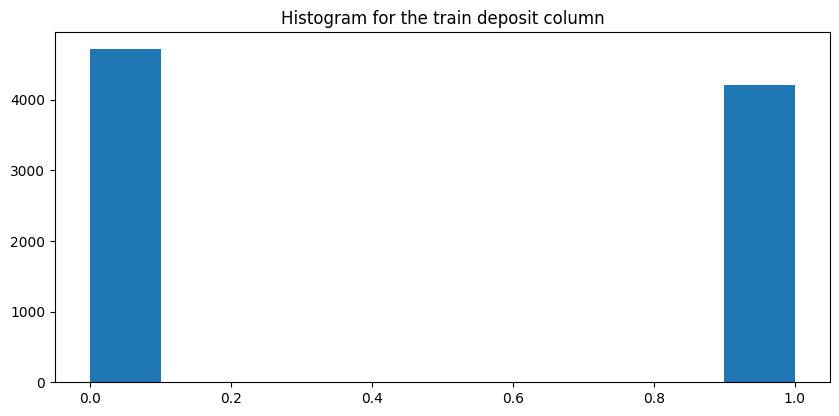

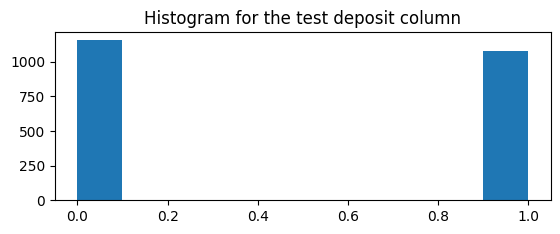

In [157]:
plt.figure(figsize = (10, 10)) #output figure
plt.subplot(2, 1, 1) #subplot index
plt.hist(y_train) #plotting a histogram of the train deposit column
plt.title('Histogram for the train deposit column') #setting plot title
plt.show() #show the plot

plt.subplot(2, 1, 2) #subplot index
plt.hist(y_test) #plotting a histogram of the test deposit column
plt.title('Histogram for the test deposit column') #setting plot title
plt.show() #show the plot

## Task 5 - Training with 5-fold cross validation

### 5(a) RBF kernel SVM

Hyperparameters:
- Kernel width
- Regularization

In [158]:
#[14]
SVC().get_params() #calling the .get_params() method to get the exact parameter names to be used for defining the grid search dictionary

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [159]:
#[12]
#C - this parameter is analogous to the regularizatinol coefficient in regression
#Gamma - is inversely proportional to the variance of the gaussian kernel
grid = {'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 0.5, 1, 10]} #construccting a grid out of the ranges for gamma and C
svm_rbf = SVC() #initializing the model
grid_search = GridSearchCV(estimator = svm_rbf, param_grid= grid, cv=5, scoring = 'accuracy') #performing the grid search with 5-fold cross validation
grid_search.fit(X_train, y_train) #fitting the model on the train data

print(f"Best parameters: {grid_search.best_params_} \n Accuracy corresponding to the best parameters: {grid_search.best_score_}") #displaying the best parameters and accuracy value

Best parameters: {'C': 1, 'gamma': 0.001} 
 Accuracy corresponding to the best parameters: 0.7247158572275494


- Saving the grid search object

In [160]:
joblib.dump(grid_search, "/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_svm.joblib") #saving the grid search object to a file

['/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_svm.joblib']

- Loading the saved grid search object

In [161]:
grid_search = joblib.load("/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_svm.joblib") #loading the saved grid search object

#### Training the SVM for the best parameters

In [162]:
svm_best = SVC(gamma = grid_search.best_params_['gamma'], C = grid_search.best_params_['C'], probability=True) #Setting the parameters as the best ones found in the grid search
svm_best.fit(X_train, y_train) #Fitting the best model on the train dataset
print(f"Final validation accuracy = {accuracy_score(y_test, svm_best.predict(X_test))}") #Printing the final accuracy score

Final validation accuracy = 0.7308553515450067


- Saving the best model

In [163]:
joblib.dump(svm_best, "/content/drive/My Drive/EE353 assignments/Assignment 3/svm_best.joblib") #saving the model to a file

['/content/drive/My Drive/EE353 assignments/Assignment 3/svm_best.joblib']

- Loading the saved best model

In [164]:
svm_best = joblib.load("/content/drive/My Drive/EE353 assignments/Assignment 3/svm_best.joblib") #loading the saved model

### 5(b) Multi-layer perceptron

Hyperparameters:
- Hidden layer width
- Weight decay

In [165]:
#[14]
MLPClassifier().get_params() #calling the .get_params() method to get the exact parameter names to be used for defining the grid search dictionary

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}


- From the parameters dictioanry, it can be seen that the activation is already set to Relu in the default model.
- Also, in the default model, the output layer gives the softmax of the last hidden layer.

In [166]:
grid = {'alpha': [0.001, 0.01, 0.1, 1, 5, 10], 'hidden_layer_sizes': [(25,), (50,), (100,), (150,), (200,)]} #Grid of the parameter values to be iteratively tried
mlp = MLPClassifier(solver='adam') #initializing the model which would use an adam optimizer for loss minimization
grid_search = GridSearchCV(estimator=mlp, param_grid=grid, cv=5, scoring='accuracy') #perform grid search with cross-validation on the hidden layer width and regularization
grid_search.fit(X_train, y_train) #running the grid search

print(f"Best parameters: {grid_search.best_params_} \n Accuracy corresponding to the best parameters: {grid_search.best_score_}") #displaying the best parameters and accuracy value

Best parameters: {'alpha': 0.01, 'hidden_layer_sizes': (100,)} 
 Accuracy corresponding to the best parameters: 0.7827322373518276


- Saving the grid search object

In [167]:
joblib.dump(grid_search, "/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_mlp.joblib") #saving the grid search object to a file

['/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_mlp.joblib']

- Loading the saved grid search object


In [168]:
grid_search = joblib.load("/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_mlp.joblib") #loading the saved grid search object

#### Training the MLP for the best parameters

In [169]:
mlp_best = MLPClassifier(alpha = grid_search.best_params_['alpha'], hidden_layer_sizes = grid_search.best_params_['hidden_layer_sizes']) #Setting the parameters as the best ones found in the grid search
mlp_best.fit(X_train, y_train) #Fitting the best model on the train dataset
print(f"Final Train accuracy = {accuracy_score(y_train, mlp_best.predict(X_train))}") #Printing the final accuracy score
print(f"Final validation accuracy = {accuracy_score(y_test, mlp_best.predict(X_test))}") #Printing the final accuracy score

Final Train accuracy = 0.6820472617314369
Final validation accuracy = 0.6681594267801164


- Saving the best model

In [170]:
joblib.dump(mlp_best, "/content/drive/My Drive/EE353 assignments/Assignment 3/mlp_best.joblib") #saving the model to a file

['/content/drive/My Drive/EE353 assignments/Assignment 3/mlp_best.joblib']

- Loading the saved best model

In [171]:
mlp_best = joblib.load("/content/drive/My Drive/EE353 assignments/Assignment 3/mlp_best.joblib") #loading the saved model

### 5(c) Random forest

Hyperparameters:
- Max tree depth
- Max number of variables per node

In [172]:
#[14]
RandomForestClassifier().get_params() #calling the .get_params() method to get the exact parameter names to be used for defining the grid search dictionary

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [173]:
grid = {'max_depth': [None, 10, 20, 30, 40, 50], 'max_features': ['sqrt', 'log2', None, 0.5, 0.75, 0.9]} #Grid of the parameter values to be iteratively tried
random_forest = RandomForestClassifier() #initializing the model
grid_search = GridSearchCV(estimator=random_forest, param_grid=grid, cv=5, scoring='accuracy') #perform grid search with cross-validation
grid_search.fit(X_train, y_train) #running the grid search

print(f"Best parameters: {grid_search.best_params_} \n Accuracy corresponding to the best parameters: {grid_search.best_score_}") #displaying the best parameters and accuracy value

Best parameters: {'max_depth': 50, 'max_features': 0.5} 
 Accuracy corresponding to the best parameters: 0.8526143895408106


- Saving the grid search object

In [174]:
joblib.dump(grid_search, "/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_rf.joblib") #saving the grid search object to a file

['/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_rf.joblib']

- Loading the saved grid search object


In [175]:
grid_search = joblib.load("/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_rf.joblib") #loading the saved grid search object

#### Training the Random forest for the best parameters

In [216]:
rf_best = RandomForestClassifier(max_depth = grid_search.best_params_['max_depth'], max_features = grid_search.best_params_['max_features']) #Setting the parameters as the best ones found in the grid search
rf_best.fit(X_train, y_train) #Fitting the best model on the train dataset
print(f"Final validation accuracy = {accuracy_score(y_test, rf_best.predict(X_test))}") #Printing the final accuracy score

Final validation accuracy = 0.8607254814151366


- Saving the best model

In [219]:
joblib.dump(rf_best, "/content/drive/My Drive/EE353 assignments/Assignment 3/rf_best.joblib") #saving the model to a file

['/content/drive/My Drive/EE353 assignments/Assignment 3/rf_best.joblib']

- Loading the saved best model

In [220]:
rf_best = joblib.load("/content/drive/My Drive/EE353 assignments/Assignment 3/rf_best.joblib") #loading the saved model

## Task 6 - Feature importance

- Permutation importance [15]: This is evaluated by iterating through the features and randomly shuffling the corresponding feature values followed by re-evaluating the model for each iteration. The feature importance is given by the difference in the accuracy score between the accuracy for the original dataset and the permuted one.
- A benefit of using this feature importance technique is that it can assist in improving the accuracy of the model by feature elimination.

### 1. The RBF kernel SVM

Text(0.5, 1.0, 'Permutation importance for the RBF-SVM model')

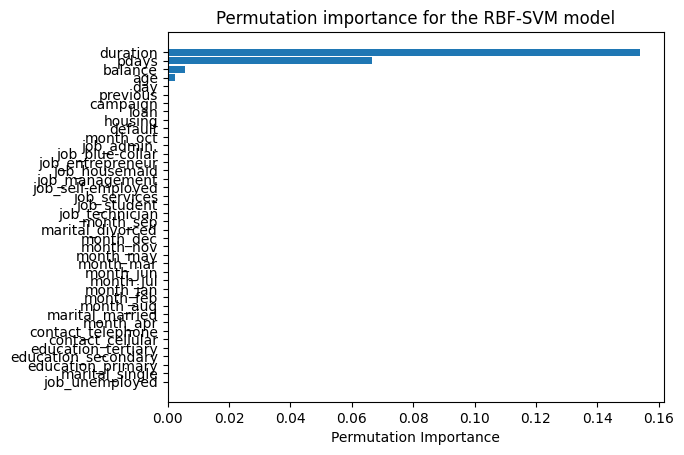

In [179]:
#[15]
perm_importance_svm = permutation_importance(svm_best, X_test, y_test) #permutation importance function from sklearn
features = np.array(X_train.columns) #creating a numpy array out of the column names for iteration
sorted_idx = perm_importance_svm.importances_mean.argsort() #sorting the averaged importance for each feature in the perm_importance object

plt.barh(features[sorted_idx], perm_importance_svm.importances_mean[sorted_idx]) #Bar plot for the sorted permutation index values
plt.xlabel("Permutation Importance") #setting plot x axis label
plt.title("Permutation importance for the RBF-SVM model") #plot title

### 2. The Multi-Layered Perceptron

Text(0.5, 1.0, 'Permutation importance for the MLP model')

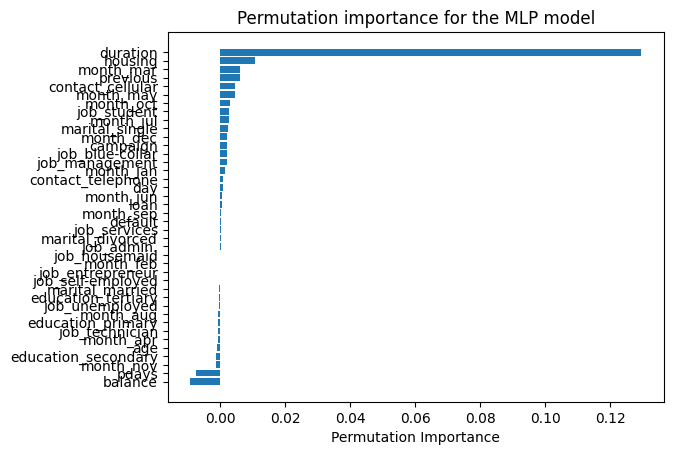

In [180]:
#[15]
perm_importance_mlp = permutation_importance(mlp_best, X_test, y_test) #permutation importance function from sklearn
features = np.array(X_train.columns) #creating a numpy array out of the column names for iteration
sorted_idx_mlp = perm_importance_mlp.importances_mean.argsort() #sorting the averaged importance for each feature in the perm_importance object

plt.barh(features[sorted_idx_mlp], perm_importance_mlp.importances_mean[sorted_idx_mlp]) #Bar plot for the sorted permutation index values
plt.xlabel("Permutation Importance") #setting plot x axis label
plt.title("Permutation importance for the MLP model") #plot title

### 3. The Random forest model

Text(0.5, 1.0, 'Permutation importance for the Random Forest model')

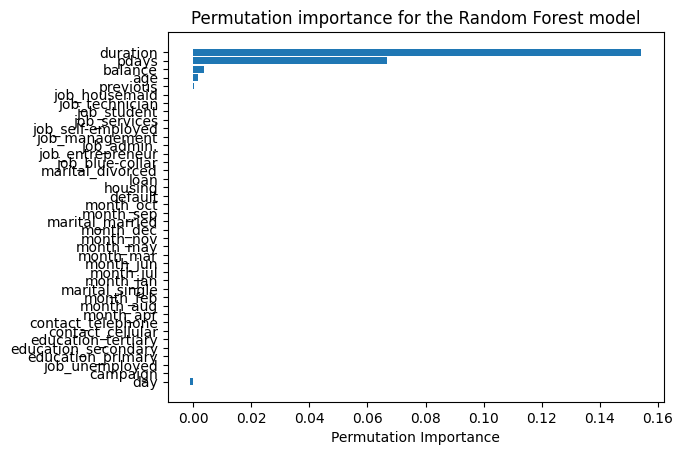

In [181]:
#[15]
perm_importance_rf = permutation_importance(rf_best, X_test, y_test) #permutation importance function from sklearn
features = np.array(X_train.columns) #creating a numpy array out of the column names for iteration
sorted_idx_rf = perm_importance_rf.importances_mean.argsort() #sorting the averaged importance for each feature in the perm_importance object

plt.barh(features[sorted_idx_rf], perm_importance_rf.importances_mean[sorted_idx_rf]) #Bar plot for the sorted permutation index values
plt.xlabel("Permutation Importance") #setting plot x axis label
plt.title("Permutation importance for the Random Forest model") #plot title

## Task 7 - Removing features to enhance model accuracy

- Now the advantage of using a comparative approach (the permutation importance) for feature importance measurement will be leveraged.
- The columns showing a negative permutation importance are the ones, that when shuffled give out a more accurate model when trained on the corresponding modified data.
- Also, for another layer of checking, recursive feature elimination will be used, invoking [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html). [16]
- However, the final decision for dropping the right columns will be made based on the more accurate feature selection approach.

### 1. The RBF kernel SVM

- Columns to be removed - Permutation Importance

In [182]:
svm_neg_imp = [] #this list will hold the columns with negative mean permutation importances
print("Columns to be removed as per permutation importance:") #printing the columns to be removed
for i in range(len(perm_importance_svm.importances_mean)): #iterating through the mean permutation importances array to search for negative values
    if(perm_importance_svm.importances_mean[i] < 0): #if the mean permutation importance is negative for this column
       svm_neg_imp.append(features[i]) #appending the column name to the negative permutation array
       print(features[i]) #Printing the ith column name
filtered_data_num_removed_svm = filtered_data_num.drop(svm_neg_imp, axis = 1) #removing the columns with negative permutation importance

Columns to be removed as per permutation importance:


- Train test split

In [183]:
X_train_removed_svm, X_test_removed_svm, y_train_removed_svm, y_test_removed_svm = train_test_split(filtered_data_num_removed_svm.drop(['deposit'], axis = 1), filtered_data_num_removed_svm['deposit'], test_size=0.2) #generating the test and train split for the new data

- Re-initiating the grid search

In [184]:
#[12]
grid = {'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 0.5, 1, 10]} #construccting a grid out of the ranges for gamma and C
svm_rbf = SVC() #initializing the model
grid_search = GridSearchCV(estimator = svm_rbf, param_grid= grid, cv=5, scoring = 'accuracy') #performing the grid search with 5-fold cross validation
grid_search.fit(X_train_removed_svm, y_train_removed_svm) #fitting the model on the train data

print(f"Best parameters: {grid_search.best_params_} \n Accuracy corresponding to the best parameters: {grid_search.best_score_}") #displaying the best parameters and accuracy value

KeyboardInterrupt: 

- Saving the grid search object

In [ ]:
joblib.dump(grid_search, "/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_svm_removed.joblib") #saving the grid search object to a file

- Loading the saved grid search object

In [ ]:
grid_search = joblib.load("/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_svm_removed.joblib") #loading the saved grid search object

- Training the best model

In [240]:
svm_removed_best = SVC(gamma = grid_search.best_params_['gamma'], C = grid_search.best_params_['C'], probability=True) #Setting the parameters as the best ones found in the grid search
svm_removed_best.fit(X_train_removed_svm, y_train_removed_svm) #Fitting the best model on the train dataset
print(f"Final validation accuracy = {accuracy_score(y_test_removed_svm, svm_removed_best.predict(X_test_removed_svm))}") #Printing the final accuracy score
print(f"Improvement in Validation accuracy after removing the negatively important columns = {accuracy_score(y_test_removed_svm, svm_removed_best.predict(X_test_removed_svm)) - accuracy_score(y_test, svm_best.predict(X_test))}") #Printing the accuracy improvement

Final validation accuracy = 0.7317510076130765
Improvement in Validation accuracy after removing the negatively important columns = 0.00089565606806985


- Saving the best model

In [255]:
joblib.dump(svm_removed_best, "/content/drive/My Drive/EE353 assignments/Assignment 3/svm_removed_best.joblib") #saving the model to a file

['/content/drive/My Drive/EE353 assignments/Assignment 3/svm_removed_best.joblib']

- Loading the saved best model

In [256]:
svm_removed_best = joblib.load("/content/drive/My Drive/EE353 assignments/Assignment 3/svm_removed_best.joblib") #loading the saved model

### 2. The Multi-Layered Perceptron

- Columns to be removed - Permutation importance

In [185]:
mlp_neg_imp = [] #this list will hold the columns with negative mean permutation importances
print("Columns to be removed as per permutation importance:") #printing the columns to be removed
for i in range(len(perm_importance_mlp.importances_mean)): #iterating through the mean permutation importances array to search for negative values
    if(perm_importance_mlp.importances_mean[i] < 0): #if the mean permutation importance is negative for this column
       mlp_neg_imp.append(features[i]) #appending the column name to the negative permutation array
       print(features[i]) #Printing the ith column name
filtered_data_num_removed_mlp = filtered_data_num.drop(mlp_neg_imp, axis = 1) #removing the columns with negative permutation importance

Columns to be removed as per permutation importance:
age
balance
pdays
job_entrepreneur
job_housemaid
job_self-employed
job_technician
job_unemployed
marital_married
education_primary
education_secondary
education_tertiary
month_apr
month_aug
month_feb
month_nov


- Train test split

In [186]:
X_train_removed_mlp, X_test_removed_mlp, y_train_removed_mlp, y_test_removed_mlp = train_test_split(filtered_data_num_removed_mlp.drop(['deposit'], axis = 1), filtered_data_num_removed_mlp['deposit'], test_size=0.2) #generating the test and train split for the new data

- Re-initiating the grid search

In [187]:
grid = {'alpha': [0.001, 0.01, 0.1, 1, 5, 10], 'hidden_layer_sizes': [(25,), (50,), (100,), (150,), (200,)]} #Grid of the parameter values to be iteratively tried
mlp = MLPClassifier(solver='adam') #initializing the model which would use an adam optimizer for loss minimization
grid_search = GridSearchCV(estimator=mlp, param_grid=grid, cv=5, scoring='accuracy') #perform grid search with cross-validation on the hidden layer width and regularization
grid_search.fit(X_train_removed_mlp, y_train_removed_mlp) #running the grid search

print(f"Best parameters: {grid_search.best_params_} \n Accuracy corresponding to the best parameters: {grid_search.best_score_}") #displaying the best parameters and accuracy value

Best parameters: {'alpha': 0.01, 'hidden_layer_sizes': (50,)} 
 Accuracy corresponding to the best parameters: 0.8181208967349537


- Saving the grid search object

In [188]:
joblib.dump(grid_search, "/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_mlp_removed.joblib") #saving the grid search object to a file

['/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_mlp_removed.joblib']

- Loading the saved grid search object


In [189]:
grid_search = joblib.load("/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_mlp_removed.joblib") #loading the saved grid search object

- Training the best model

In [190]:
mlp_removed_best = MLPClassifier(alpha = grid_search.best_params_['alpha'], hidden_layer_sizes = grid_search.best_params_['hidden_layer_sizes']) #Setting the parameters as the best ones found in the grid search
mlp_removed_best.fit(X_train_removed_mlp, y_train_removed_mlp) #Fitting the best model on the train dataset
print(f"Final validation accuracy = {accuracy_score(y_test_removed_mlp, mlp_removed_best.predict(X_test_removed_mlp))}") #Printing the final accuracy score
print(f"Improvement in Validation accuracy after removing the negatively important columns = {accuracy_score(y_test_removed_mlp, mlp_removed_best.predict(X_test_removed_mlp)) - accuracy_score(y_test, mlp_best.predict(X_test))}") #Printing the accuracy improvement

Final validation accuracy = 0.8199731303179579
Improvement in Validation accuracy after removing the negatively important columns = 0.15181370353784152


- Saving the best model

In [191]:
joblib.dump(mlp_removed_best, "/content/drive/My Drive/EE353 assignments/Assignment 3/mlp_removed_best.joblib") #saving the model to a file

['/content/drive/My Drive/EE353 assignments/Assignment 3/mlp_removed_best.joblib']

- Loading the saved best model

In [192]:
mlp_removed_best = joblib.load("/content/drive/My Drive/EE353 assignments/Assignment 3/mlp_removed_best.joblib") #loading the saved model

### 3. The Random forest model

- Columns to be removed - Permutation importance

In [193]:
rf_neg_imp = [] #this list will hold the columns with negative mean permutation importances
print("Columns to be removed:") #printing the columns to be removed
for i in range(len(perm_importance_rf.importances_mean)): #iterating through the mean permutation importances array to search for negative values
    if(perm_importance_rf.importances_mean[i] < 0): #if the mean permutation importance is negative for this column
       rf_neg_imp.append(features[i]) #appending the column name to the negative permutation array
       print(features[i]) #Printing the ith column name
filtered_data_num_removed_rf = filtered_data_num.drop(rf_neg_imp, axis = 1) #removing the columns with negative permutation importance

Columns to be removed:
day
campaign


- Columns to be removed - RFECV

In [222]:
rf_rfecv = [] #this list will hold the columns to be removed as per RFECV

estimator = RandomForestClassifier(max_depth = rf_best.max_depth, max_features = rf_best.max_features) #initializing and setting the parameters for the random forest
selector_rf = RFECV(estimator, step=1, cv=5) #setting up the recursive feature elimination with 5 fold cross validation
selector_rf = selector_rf.fit(X_train, y_train) #fitting the selector on the dataset

print("Columns to be removed as per RFECV:") #printing the columns to be removed
for i in range(len(selector_rf.ranking_)): #iterating through the rankings: = 1 for selected columns, /= for rejected columns
    if(selector_rf.ranking_[i] != 1): #reject these columns
       rf_rfecv.append(features[i]) #appending the column name to the rejected columns array
       print(features[i]) #Printing the ith column name
filtered_data_num_removed_rf_rfecv = filtered_data_num.drop(rf_rfecv, axis = 1) #removing the rejected columns

Columns to be removed as per RFECV:
default
job_admin.
job_entrepreneur
job_housemaid
job_self-employed
job_services
job_student
job_technician
job_unemployed
marital_divorced
education_primary
contact_telephone
month_dec
month_jan


- Train test split

In [223]:
X_train_removed_rf, X_test_removed_rf, y_train_removed_rf, y_test_removed_rf = train_test_split(filtered_data_num_removed_rf.drop(['deposit'], axis = 1), filtered_data_num_removed_rf['deposit'], test_size=0.2) #generating the test and train split for the new data
X_train_removed_rf_rfecv, X_test_removed_rf_rfecv, y_train_removed_rf_rfecv, y_test_removed_rf_rfecv = train_test_split(filtered_data_num_removed_rf_rfecv.drop(['deposit'], axis = 1), filtered_data_num_removed_rf_rfecv['deposit'], test_size=0.2) #generating the test and train split for the new data

- Re-initiating the grid search

In [224]:
grid = {'max_depth': [None, 10, 20, 30, 40, 50], 'max_features': ['sqrt', 'log2', None, 0.5, 0.75, 0.9]} #Grid of the parameter values to be iteratively tried
random_forest = RandomForestClassifier() #initializing the model
grid_search = GridSearchCV(estimator=random_forest, param_grid=grid, cv=5, scoring='accuracy') #perform grid search with cross-validation
grid_search.fit(X_train_removed_rf, y_train_removed_rf) #running the grid search

print(f"Best parameters: {grid_search.best_params_} \n Accuracy corresponding to the best parameters: {grid_search.best_score_}") #displaying the best parameters and accuracy value

Best parameters: {'max_depth': 40, 'max_features': 'sqrt'} 
 Accuracy corresponding to the best parameters: 0.8451092060564427


- Saving the grid search object

In [225]:
joblib.dump(grid_search, "/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_rf_removed.joblib") #saving the grid search object to a file

['/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_rf_removed.joblib']

- Loading the saved grid search object


In [226]:
grid_search = joblib.load("/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_rf_removed.joblib") #loading the saved grid search object

- Training the best model

In [227]:
rf_removed_best = RandomForestClassifier(max_depth = grid_search.best_params_['max_depth'], max_features = grid_search.best_params_['max_features']) #Setting the parameters as the best ones found in the grid search
rf_removed_best.fit(X_train_removed_rf, y_train_removed_rf) #Fitting the best model on the train dataset
print(f"Final validation accuracy = {accuracy_score(y_test_removed_rf, rf_removed_best.predict(X_test_removed_rf))}") #Printing the final accuracy score
print(f"Improvement in Validation accuracy after removing the negatively important columns = {accuracy_score(y_test_removed_rf, rf_removed_best.predict(X_test_removed_rf)) - accuracy_score(y_test, rf_best.predict(X_test))}") #Printing the accuracy improvement

Final validation accuracy = 0.8338557993730408
Improvement in Validation accuracy after removing the negatively important columns = -0.026869682042095833


- Saving the best model

In [228]:
joblib.dump(rf_removed_best, "/content/drive/My Drive/EE353 assignments/Assignment 3/rf_removed_best.joblib") #saving the model to a file

['/content/drive/My Drive/EE353 assignments/Assignment 3/rf_removed_best.joblib']

- Loading the saved best model

In [229]:
rf_removed_best = joblib.load("/content/drive/My Drive/EE353 assignments/Assignment 3/rf_removed_best.joblib") #loading the saved model

- Grid search for RFECV

In [230]:
grid = {'max_depth': [None, 10, 20, 30], 'max_features': ['sqrt', 'log2', None, 0.5, 0.75]} #Grid of the parameter values to be iteratively tried
random_forest = RandomForestClassifier() #initializing the model
grid_search = GridSearchCV(estimator=random_forest, param_grid=grid, cv=5, scoring='accuracy') #perform grid search with cross-validation
grid_search.fit(X_train_removed_rf_rfecv, y_train_removed_rf_rfecv) #running the grid search

print(f"Best parameters: {grid_search.best_params_} \n Accuracy corresponding to the best parameters: {grid_search.best_score_}") #displaying the best parameters and accuracy value

Best parameters: {'max_depth': 30, 'max_features': 0.5} 
 Accuracy corresponding to the best parameters: 0.8502643969121803


- Saving the grid search object

In [231]:
joblib.dump(grid_search, "/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_rf_rfecv.joblib") #saving the grid search object to a file

['/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_rf_rfecv.joblib']

- Loading the saved grid search object


In [232]:
grid_search = joblib.load("/content/drive/My Drive/EE353 assignments/Assignment 3/grid_search_rf_rfecv.joblib") #loading the saved grid search object

- Training the best rfecv model

In [233]:
rf_removed_best_rfecv = RandomForestClassifier(max_depth = grid_search.best_params_['max_depth'], max_features = grid_search.best_params_['max_features']) #Setting the parameters as the best ones found in the grid search
rf_removed_best_rfecv.fit(X_train_removed_rf_rfecv, y_train_removed_rf_rfecv) #Fitting the best model on the train dataset
print(f"Final validation accuracy = {accuracy_score(y_test_removed_rf_rfecv, rf_removed_best_rfecv.predict(X_test_removed_rf_rfecv))}") #Printing the final accuracy score
print(f"Improvement in Validation accuracy after removing the negatively important columns = {accuracy_score(y_test_removed_rf_rfecv, rf_removed_best_rfecv.predict(X_test_removed_rf_rfecv)) - accuracy_score(y_test, rf_best.predict(X_test))}") #Printing the accuracy improvement

Final validation accuracy = 0.8611733094491715
Improvement in Validation accuracy after removing the negatively important columns = 0.0004478280340348695


- Saving the best model

In [234]:
joblib.dump(rf_removed_best_rfecv, "/content/drive/My Drive/EE353 assignments/Assignment 3/rf_removed_best_rfecv.joblib") #saving the model to a file

['/content/drive/My Drive/EE353 assignments/Assignment 3/rf_removed_best_rfecv.joblib']

- Loading the saved best model

In [235]:
rf_removed_best_rfecv = joblib.load("/content/drive/My Drive/EE353 assignments/Assignment 3/rf_removed_best_rfecv.joblib") #loading the saved model

Result:
- Permutation importance proves to be a better feature elimination technique for the random forest classifier.
- Hence, proceeding with permutation importance for feature elimination for all the above models is justified.

## Task 8 - Validating the promising models

- Following are all the models obtained after the grid searches so far.

In [272]:
#creating a dictionary for all models trained so far, consisting of the trained model, and the respective train and test datasets for the models
models = {'svm_best': [svm_best, X_train, y_train, X_test, y_test],
          'mlp_best': [mlp_best, X_train, y_train, X_test, y_test],
          'rf_best': [rf_best, X_train, y_train, X_test, y_test],
          'svm_removed_best': [svm_removed_best, X_train_removed_svm, y_train_removed_svm, X_test_removed_svm, y_test_removed_svm],
          'mlp_removed_best': [mlp_removed_best, X_train_removed_mlp, y_train_removed_mlp, X_test_removed_mlp, y_test_removed_mlp],
          'rf_removed_best': [rf_removed_best, X_train_removed_rf, y_train_removed_rf, X_test_removed_rf, y_test_removed_rf],
          'rf_removed_best_rfecv': [rf_removed_best_rfecv, X_train_removed_rf_rfecv, y_train_removed_rf_rfecv, X_test_removed_rf_rfecv, y_test_removed_rf_rfecv]}

- Following are the training accuracies for all the above models.

In [273]:
print("Model  \t Train accuracy(%) \t Train AUC_ROC") #printing the heading
for model_name, model in models.items(): #iterating through the dictionary of models
    print(f"{model_name}: \t {100*accuracy_score(model[2], model[0].predict(model[1])):.2f} \t\t {roc_auc_score(model[2], model[0].predict_proba(model[1])[:,1]):.2f}") #Print the model train accuracy and train AUC_ROC

Model  	 Train accuracy(%) 	 Train AUC_ROC
svm_best: 	 91.58 		 0.97
mlp_best: 	 68.20 		 0.73
rf_best: 	 100.00 		 1.00
svm_removed_best: 	 91.87 		 0.97
mlp_removed_best: 	 82.18 		 0.90
rf_removed_best: 	 100.00 		 1.00
rf_removed_best_rfecv: 	 99.99 		 1.00


## Validation on the test set for all the models

In [274]:
print("Model  \t Validation accuracy(%) \t Validation AUC_ROC") #printing the heading
for model_name, model in models.items(): #iterating through the dictionary of models
    print(f"{model_name}: \t {100*accuracy_score(model[4], model[0].predict(model[3]))} \t {roc_auc_score(model[4], model[0].predict_proba(model[3])[:,1])}") #Print the model train accuracy and train AUC_ROC

Model  	 Validation accuracy(%) 	 Validation AUC_ROC
svm_best: 	 73.08553515450068 	 0.7991133171096064
mlp_best: 	 66.81594267801164 	 0.7247403802134785
rf_best: 	 86.07254814151366 	 0.9258427101655302
svm_removed_best: 	 73.17510076130766 	 0.7838438599716795
mlp_removed_best: 	 81.9973130317958 	 0.8975014361417164
rf_removed_best: 	 83.38557993730407 	 0.9084604074942957
rf_removed_best_rfecv: 	 86.11733094491714 	 0.925430238910277


- The following models display a validation accuracy of above 80% and are the most promising ones:

In [275]:
final_models = {} #this will hold the final reliable models useful for the business
most_accurate_model = 0 #this string will hold the name of the most accurate model
highest_accuracy = 0 #this will hold the accuracy of the most accurate model
for model_name, model in models.items(): #iterating through the models dictionary
    accuracy = 100 * accuracy_score(model[4], model[0].predict(model[3])) #accuracy as a percentage

    if(accuracy > highest_accuracy): #checking whether to update the highest accuracy
        highest_accuracy = accuracy #updating the highest accuracy value
        most_accurate_model = model_name #updating the most accurate model

    if accuracy > 80: #select models with an accuracy of more than 80%
        print(model_name) #print the names of these models
        final_models[model_name] = model #append these models to the final models dictionary

rf_best
mlp_removed_best
rf_removed_best
rf_removed_best_rfecv


## Task 9 - Checking for generalization beyond the train data

Model to be used: The most accurate model out of the above models:

In [276]:
print(f"The most accurate model is: {most_accurate_model}") #print the name of the most accurate model

The most accurate model is: rf_removed_best_rfecv


### 9.(a) Months: June and July for test data, other months for train data

- Generating the train and test data for the given task.
- An interesting thing to check would be whether we are eliminating the month_june and month_july columns, because that would imply the need to validate the original best models rather than the ones obtained after feature elimination.

In [264]:
features_in_selected_model = final_models[most_accurate_model][1].columns #list of features used fior the most accurate model
if 'month_jun' in features_in_selected_model and 'month_jul' in features_in_selected_model: #if the columns 'month_jun' and 'month_jul' are used as features for the most accurate model
    print('safe to proceed') #print that it is safe to proceed witht the model as it is trained with the month_jun and month_jul columns
else: #if these columns are not used to train the most
    print('Choose another model') #print that it is not safe to proceed witht the model as it is not trained with the month_jun and month_jul columns

safe to proceed


In [305]:
a = list(final_models[most_accurate_model][1].columns)

In [308]:
print(a)

['age', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign', 'pdays', 'previous', 'job_blue-collar', 'job_management', 'marital_married', 'marital_single', 'education_secondary', 'education_tertiary', 'contact_cellular', 'month_apr', 'month_aug', 'month_feb', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'deposit']


In [309]:
data_9a = filtered_data_num[list(final_models[most_accurate_model][1].columns)  + ['deposit']] #feature names for the most accurate model
train_9a = data_9a[(data_9a['month_jun'] == 0) & (data_9a['month_jul'] == 0)] #train data- all the sample points takin in months other than june and july
X_train_9a = train_9a.drop(['deposit'], axis = 1) #features
y_train_9a = train_9a['deposit'] #dependent variable

test_9a = data_9a[(data_9a['month_jun'] == 1) | (data_9a['month_jul'] == 1)] #test data- all the sample points taking in months june or july
X_test_9a = test_9a.drop(['deposit'], axis = 1) #features
y_test_9a = test_9a['deposit'] #dependent variable

print(f"Data size: \n train: {X_train_9a.shape[0]} \n test: {X_test_9a.shape[0]}") #print the sizes of the train and test datasets

Data size: 
 train: 8426 
 test: 2736


- Training the model (without grid search) with the previous grid search parameters.

In [310]:
model_9a = type(final_models[most_accurate_model][0])(** final_models[most_accurate_model][0].get_params()) #getting the model type of the best model - SVM or MLP or RF
model_9a.fit(X_train_9a, y_train_9a) #fitting the model on the train data

RandomForestClassifier(max_depth=30, max_features=0.5)

- Validation on the test data.

In [311]:
print(f"Final validation accuracy = {accuracy_score(y_test_9a, model_9a.predict(X_test_9a))}") #Printing the final accuracy score
print(f"Ratio of this accuracy and the val. accuray obtained for the original model: {(accuracy_score(y_test_9a, model_9a.predict(X_test_9a))/accuracy_score(final_models[most_accurate_model][4], final_models[most_accurate_model][0].predict(final_models[most_accurate_model][3]))):.3f}") #print the ratio of the validation accuracy of the original model and the one catered to task 9

Final validation accuracy = 0.7883771929824561
Ratio of this accuracy and the val. accuray obtained for the original model: 0.915


Results
- As seen by the above ratio, the validation accuracy decreases by a very small quantity when the train-test split is uneven for the monts of june and july.
- However small it is, there's a reduction in the validation accuracy as expected, because a poorly chosen train-test split will reduce the validation accuracy due to poorer generalization of the model.

### 9.(b) Professions: Technicians for test data, other professions for the train data

- Generating the train and test data for the given task.
- A similar check must be done as was done for the existence of the month_jun and month_jul columns.

In [280]:
features_in_selected_model = final_models[most_accurate_model][1].columns #list of features used fior the most accurate model

if 'job_technician' in features_in_selected_model:  #if the column 'job_technician' is used as a feature for the most accurate model
    print('safe to proceed')   #print that it is safe to proceed witht the model as it is trained with the job_technician column
else:  #if this column is not used to train the most accurate model
    print('Choose another model') #print that it is not safe to proceed witht the model as it is not trained with the job_technician column

Choose another model


- So, the rfecv random forest features can't be used for this task, so selecting the second most accurate model: rf_best

In [316]:
most_accurate_model = 'rf_best' #updating the most accurate model as 'rf_best'

In [317]:
data_9b = filtered_data_num[list(final_models[most_accurate_model][1].columns)  + ['deposit']] #feature names for the most accurate model
train_9b = data_9b[(data_9b['job_technician'] == 0)] #train data- all the sample points taken for professions other than technicians
X_train_9b = train_9b.drop(['deposit'], axis = 1) #features
y_train_9b = train_9b['deposit'] #dependent variable

test_9b = data_9b[(data_9b['job_technician'] == 1)] #test data- all the sample points taken for technicians
X_test_9b = test_9b.drop(['deposit'], axis = 1) #features
y_test_9b = test_9b['deposit'] #dependent variable

print(f"Data size: \n train: {X_train_9b.shape[0]} \n test: {X_test_9b.shape[0]}")

Data size: 
 train: 9339 
 test: 1823


- Training the model (without grid search) with the previous grid search parameters.

In [318]:
model_9b = type(final_models[most_accurate_model][0])(** final_models[most_accurate_model][0].get_params()) #getting the model type of the best model - SVM or MLP or RF
model_9b.fit(X_train_9b, y_train_9b) #fitting the model on the train data

RandomForestClassifier(max_depth=50, max_features=0.5)

- Validation on the test data.

In [319]:
print(f"Final validation accuracy = {accuracy_score(y_test_9b, model_9b.predict(X_test_9b))}") #Printing the final accuracy score
print(f"Ratio of this accuracy and the val. accuray obtained for the original model: {(accuracy_score(y_test_9b, model_9b.predict(X_test_9b))/accuracy_score(final_models[most_accurate_model][4], final_models[most_accurate_model][0].predict(final_models[most_accurate_model][3]))):.3f}")

Final validation accuracy = 0.85957213384531
Ratio of this accuracy and the val. accuray obtained for the original model: 0.999


Results
- As seen by the above ratio, the validation accuracy decreases by a very small quantity when the train-test split is uneven for the profession of technician.
- This is similar to the result obtained for 9.(a)

# Objective 2

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = '/content/drive/My Drive/EE353 assignments/Assignment 3/hymenoptera_data' #use this directory for collab use
data_dir = 'hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

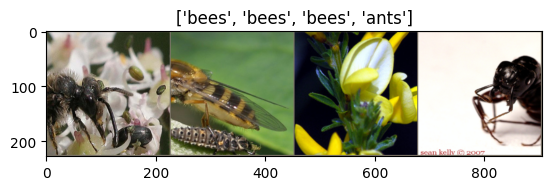

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

In [ ]:
#[8]
torch.save(model_conv, 'model_conv.pth') #saving the model

In [ ]:
#[8]
model_loaded = torch.load('model_conv.pth', map_location=torch.device('cpu')) #loading the model, mapping the GPU-trained model to the CPU

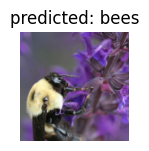

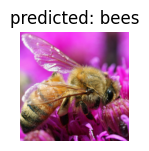

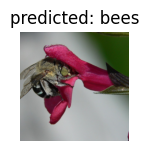

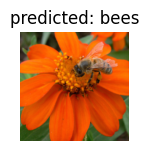

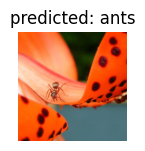

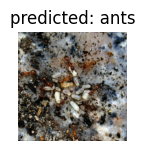

In [ ]:
visualize_model(model_loaded)

plt.ioff()
plt.show()

In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

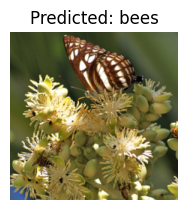

In [ ]:
visualize_model_predictions(
    model_loaded,
    # img_path='/content/drive/My Drive/EE353 assignments/Assignment 3/hymenoptera_data/val/bees/72100438_73de9f17af.jpg' #directory for collab use
    img_path='hymenoptera_data/val/bees/72100438_73de9f17af.jpg' #directory for pc use
)

plt.ioff()
plt.show()

## Task 11 - Function to extract ResNet18 features

In [ ]:
def extract_resnet_18_features(model, img_path):
    model = nn.Sequential(*list(model.children())[:-1]) # Remove the last fully connected layer (the classifier)
    model.eval() #setting the model in evaluation mode
    img = Image.open(img_path) #opening the image at the given path
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad(): #avoiding gradient calculation during inference
        feature_vector = model(img)

    return feature_vector[0][:,0,0] #the feature vector is 1x512x1x1, the first, third and forth dimensions represent redundant information, the frature values themselves are in the second dimension

### Testing the feature extractor function

In [ ]:
feat_vctr = extract_resnet_18_features(
    model_loaded,
    img_path='hymenoptera_data/val/bees/72100438_73de9f17af.jpg' #directory for pc use
)
feat_vctr.shape

torch.Size([512])

### Extracting features for all the images in the train set

In [ ]:
features_train_bees = [] #list to store the features for the bees train data
features_train_ants = [] #list to store the features for the ants train data

features_test_bees = [] #list to store the features for the bees test data
features_test_ants = [] #list to store the features for the ants test data

#[9]
bees_train_folder_path = 'hymenoptera_data/train/bees/' #path to ants train data folder

for file_name in os.listdir(bees_train_folder_path): #looping through the entire folder
    img_path = os.path.join(bees_train_folder_path, file_name)  # Full path to the image
    feat_vctr = extract_resnet_18_features(model_loaded, img_path)  # Extract features using the function made for resnet18
    features_train_bees.append(feat_vctr)  #append to the list of bee image features

ants_train_folder_path = 'hymenoptera_data/train/ants/' #path to ants train data folder

for file_name in os.listdir(ants_train_folder_path): #looping through the entire folder
    img_path = os.path.join(ants_train_folder_path, file_name)  # Full path to the image
    feat_vctr = extract_resnet_18_features(model_loaded, img_path)  # Extract features using the function made for resnet18
    features_train_ants.append(feat_vctr)  #append to the list of ant image features

bees_test_folder_path = 'hymenoptera_data/val/bees/' #path to ants train data folder

for file_name in os.listdir(bees_test_folder_path): #looping through the entire folder
    img_path = os.path.join(bees_test_folder_path, file_name)  # Full path to the image
    feat_vctr = extract_resnet_18_features(model_loaded, img_path)  # Extract features using the function made for resnet18
    features_test_bees.append(feat_vctr)  #append to the list of bee image features

ants_test_folder_path = 'hymenoptera_data/val/ants/' #path to ants train data folder

for file_name in os.listdir(ants_test_folder_path): #looping through the entire folder
    img_path = os.path.join(ants_test_folder_path, file_name)  # Full path to the image
    feat_vctr = extract_resnet_18_features(model_loaded, img_path)  # Extract features using the function made for resnet18
    features_test_ants.append(feat_vctr)  #append to the list of ant image features

In [ ]:
features_train_bees = np.array(features_train_bees) #converting to a numpy array for ease of programming
features_train_ants = np.array(features_train_ants) #converting to a numpy array for ease of programming

features_test_bees = np.array(features_test_bees) #converting to a numpy array for ease of programming
features_test_ants = np.array(features_test_ants) #converting to a numpy array for ease of programming

In [ ]:
print(f"Shape of the feature array for the bees train data: {features_train_bees.shape}\nShape of the feature array for the ants train data: {features_train_ants.shape}")
print(f"Shape of the feature array for the bees validation data: {features_test_bees.shape}\nShape of the feature array for the ants validation data: {features_test_ants.shape}")

Shape of the feature array for the bees train data: (121, 512)
Shape of the feature array for the ants train data: (123, 512)
Shape of the feature array for the bees validation data: (83, 512)
Shape of the feature array for the ants validation data: (70, 512)


## Task 12 - Comparing logistic regression and random forest

### 0. Curating the dataset, consisiting of the feature vectors and the corresponding ant/bee tags

In [ ]:
feature_train_data = pd.DataFrame(np.append(features_train_bees, features_train_ants, axis = 0)) #constructing a dataframe from the feature matrix
feature_test_data = pd.DataFrame(np.append(features_test_bees, features_test_ants, axis = 0)) #constructing a dataframe from the feature matrix

train_labels = [] #stores the train labels
test_labels = [] #stores the test labels

train_labels = np.append(np.ones(features_train_bees.shape[0]), np.zeros(features_train_ants.shape[0])) #bee encoded as 1 and ant encoded as 0
test_labels = np.append(np.ones(features_test_bees.shape[0]), np.zeros(features_test_ants.shape[0])) #bee encoded as 1 and ant encoded as 0

### 1. L2 regularized logistic regression on the extracted features

In [ ]:
#[10]
lambda1 = 1
log_reg_model = LogisticRegression(penalty='l2', C=1/lambda1, max_iter=200) #Creating the regularized model with C = 1/lambda1
log_reg_model.fit(feature_train_data, train_labels) #fitting the logistic regression model on the train data of features
y_pred = log_reg_model.predict(feature_test_data) #array of predicted labels for the validation data
accuracy = accuracy_score(test_labels, y_pred) #accuracy of the prediction
f1 = f1_score(test_labels, y_pred)  #F1 score of the prediction
print(f"F1 Score for the model with lambda1 = {lambda1}: {f1:.4f}")  #printing the accuracy
print(f"Fractional Accuracy of the Logistic Regression model with lambda1 = {lambda1}: {accuracy:.2f}") #printing the accuracy

F1 Score for the model with lambda1 = 1: 0.9576
Fractional Accuracy of the Logistic Regression model with lambda1 = 1: 0.95


## 2. Random forest with a grid search on max depth and number of trees

In [ ]:
#[11]
param_grid = {
    'n_estimators': [25, 50, 100, 150, 200, 250, 300, 350], #number of tree values to test for in the grid search
    'max_depth': [3, 5, 10, 15, 20, 25] #max depth values to test for in the grid search
}

rf = RandomForestClassifier() #Initializing the random forest classifier model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy') #Perform grid search with cross-validation on the max depth and the number of trees
grid_search.fit(feature_train_data, train_labels) #Fit the model on the features dataset

best_params = grid_search.best_params_ #Get the best parameters
best_score = grid_search.best_score_ #Get the best score

print(f"Best Parameters: {best_params}") #print the best parameters
print(f"Best Cross-Validation Accuracy: {best_score:.4f}") #print the best score

Best Parameters: {'max_depth': 25, 'n_estimators': 50}
Best Cross-Validation Accuracy: 0.9468


In [ ]:
#training the final model with the best parameter values
rf_final = RandomForestClassifier(n_estimators = best_params['n_estimators'], max_depth = best_params['max_depth']) #initializing the model with the best values of the parameters
rf_final.fit(feature_train_data, train_labels) #Fitting the model on the features dataset
y_pred = rf_final.predict(feature_test_data)
accuracy = accuracy_score(test_labels, y_pred) #accuracy of the prediction
f1 = f1_score(test_labels, y_pred)  #F1 score of the prediction
print(f"F1 Score for the best parameter random forest: {f1:.4f}") #printing the F1 score
print(f"Fractional Accuracy of the best parameter random forest: {accuracy:.2f}") #printing the accuracy

### Results:
- Ensemble learning through random forest proved to be more effective than the linear predictor as depicted by the accuracy and f1 score values for the two models
- Through a grid search for the best values of the number of trees and max tree depth from the chosen grid of parameters, the best values were found to be: max depth = 20, number of trees = 350

# References:  
[1]: Description of the dataset from the UCI ML repository website: https://archive.ics.uci.edu/dataset/222/bank+marketing  
[2]: ChatGPT was used for basic excel tasks such as finding the distribution of entries in a column, listing the unique entries in a column, etc.  
[3]: ChatGPT prompt: How to copy a dataframe into another dataframe.  
[4]: ChatGPT prompt: Pandas function for one-hot encoding of categorical columns in a dataframe  
[5]: ChatGPT prompt: Construct a correlation matrix indiced by the data column names rather than the column/row indices  
[6]: ChatGPT prompt: Dropping and resetting the row indices for a certain column data  
[7]: ChatGPT prompt: How to get an annotated heatamp with 'X' markers in the cells where the correlation > threshold   
[8]: ChatGPT prompt: How to save my model as a model file in torch and then load it for future use.  
[9]: ChatGPT prompt: How to apply a python function iteratively on multiple file paths.  
[10]: ChatGPT prompt: Logistic regression with adjustable regularization using scikit-learn.  
[11]: ChatGPT prompt: Random forest with a grid search on max depth and number of trees using scikit-learn.  
[12]: The scikit documentation was referred to for examples on SVM implementation: [scikit-learn SVM example](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters)  
[13]: The scikit documentation for implementing an MLP was referred to: [scikit-learn MLP example](https://scikit-learn.org/stable/modules/neural_networks_supervised)  
[14]: ChatGPT prompt: How to get parameter names of a scikit model  
[15]: For info on Permutation importance, the following website was referred: [Feature importance for RBF-SVM](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html).  
[16]: Tutorial and examples on recursive feature elimination: [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html).  
